# [GD12] 번역가는 대화에도 능하다

# 12-1. 들어가며
좋은 번역을 만드는 데에는 무슨 능력이 필요할까요? 가장 먼저 떠오르는 것은 역시 언어 능력이죠! 적어도 번역하고자 하는 언어는 통달해야 좋은 번역을 해낼 수 있을 것 같습니다. 하지만 뛰어난 언어 실력만으로 가능할까요?

"Lost In Translation"은 동명의 영화로 유명해진 말인데요, 번역이 언어적 의미 너머의 맥락과 함의 또한 유실 없이 전달해야 함을 시사합니다. 동시에 문화적 차이가 존재하는 한 절대 사라질 수 없는 말이기도 하죠. 번역가들은 이 Lost In Translation을 최소화하기 위해 자신과의 싸움을 하고, 그렇게 탄생한 멋진 결과물은 한글 패치 잘 되었다는 극찬을 받게 됩니다. ^_^

말하고 싶은 것은, 번역가들의 번역이 단순히 언어를 변환하는 과정에 그치는 것이 아니라 원문을 이해하고 그 이해를 바탕으로 새로운 글을 작문하여 탄생한다는 겁니다. 그렇기에 번역에 능숙한 이들은 대체로 언변도 좋고, 대화에도 능합니다. 언어적 이해 능력이 뛰어나니까요! 번역가의 멋진 면모를 볼 수 있는 재미난 영상을 하나 첨부해드리니, 시간 날 때 가볍게 살펴보세요 😃

https://youtu.be/8zfYINYNS38

인공지능도 마찬가지입니다. 번역을 잘 해낼 수 있는 모델은 곧 언어를 잘 이해할 수 있는 모델이기도 해요. 그래서 번역을 잘하는 트랜스포머가 자언어 이해(Natural Language Understanding) 모델의 근간이 되는 거죠! 질문과 답변을 주고받는 것 또한 제법 높은 수준의 자연어 이해를 요구하는데, 이것도 잘 해낼 수 있을지 이번 코스에서 함께 확인해 보도록 해요. 번역 모델을 활용한 챗봇 만들기! 얼른 시작해 볼까요?

## 준비물
아래 명령어를 통해 디렉토리를 만들고 준비해 놓은 데이터를 연결해 주세요.
```
$ mkdir -p ~/aiffel/transformer_chatbot/data
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data
```

# 12-2. 번역 데이터 준비
먼저 번역 모델이 있어야 챗봇을 만들 수 있겠죠? 이번 실습에선 접근성이 좋은 영어-스페인어 데이터를 사용하도록 하겠습니다.

## 라이브러리와 데이터 준비하기
필요한 라이브러리를 import 해주세요.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm   # sentence piece
from nltk.translate.bleu_score import sentence_bleu   # BLEU Score
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


영어-스페인어 데이터를 다운로드해 주세요.

In [2]:
zip_path = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

print('슝=3')

2654208/2638744 [==============================] - 0s 0us/step
슝=3



다운로드한 데이터가 어떤 지 한 번 열어봅시다. 중복된 데이터가 있을 수 있으니 list와 set을 사용해 처리해 줍니다.



In [3]:
file_path = os.path.dirname(zip_path)+"/spa-eng/spa.txt"

with open(file_path, "r") as f:
    spa_eng_sentences = f.read().splitlines()

spa_eng_sentences = list(set(spa_eng_sentences)) 
total_sentence_count = len(spa_eng_sentences)
print("Example:", total_sentence_count)

for sen in spa_eng_sentences[0:100][::20]: 
    print(">>", sen)

Example: 118964
>> Tom said that he had been cleaning the house all day.	Tom dijo que había estado limpiando la casa el día entero.
>> Tom admitted that he had been defeated.	Tom admitió que había sido derrotado.
>> Do you wash your hands before meals?	¿Te lavas las manos antes de las comidas?
>> Read it one more time, please.	Léelo una vez más, por favor.
>> Read whatever you like.	Lee lo que quieras.


한 줄에 영어와 스페인어가 둘 다 들어 있네요.

가벼운 전처리를 해줍시다. 먼저 전처리 함수를 만들어 볼까요?

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

print("슝=3")

슝=3


모든 데이터에 대해서 같은 전처리를 해줄게요.

In [5]:
spa_eng_sentences = list(map(preprocess_sentence, spa_eng_sentences))

print('슝=3')

슝=3


이제 테스트에 사용할 데이터를 따로 떼어냅니다. 전체 데이터의 0.5% 정도를 테스트용으로 사용할게요.

In [6]:
test_sentence_count = total_sentence_count // 200
print("Test Size: ", test_sentence_count)
print("\n")

train_spa_eng_sentences = spa_eng_sentences[:-test_sentence_count]
test_spa_eng_sentences = spa_eng_sentences[-test_sentence_count:]
print("Train Example:", len(train_spa_eng_sentences))
for sen in train_spa_eng_sentences[0:100][::20]: 
    print(">>", sen)
print("\n")
print("Test Example:", len(test_spa_eng_sentences))
for sen in test_spa_eng_sentences[0:100][::20]: 
    print(">>", sen)

Test Size:  594


Train Example: 118370
>> tom said that he had been cleaning the house all day.	tom dijo que había estado limpiando la casa el día entero.
>> tom admitted that he had been defeated.	tom admitió que había sido derrotado.
>> do you wash your hands before meals?	¿te lavas las manos antes de las comidas?
>> read it one more time, please.	léelo una vez más, por favor.
>> read whatever you like.	lee lo que quieras.


Test Example: 594
>> i was told you were reliable.	me dijeron que eras de fiar.
>> does it really matter what i think?	¿realmente importa lo que yo pienso?
>> i don't know what tom thought.	no sé en qué pensó tom.
>> find out what hotel they're living at.	entérese del hotel en que viven.
>> their marriage broke up last year.	su matrimonio se rompió el año pasado.


한 줄에 포함되어 있는 영어와 스페인어를 분리해 줍니다. 영어 문장과 스페인어 문장이 tab으로 연결되어 있으니 split('\t')을 사용하면 나눌 수 있겠네요. tab 이전이 영어, 이후가 스페인어 문장입니다.

먼저 함수를 만들어 줍니다.

In [7]:
def split_spa_eng_sentences(spa_eng_sentences):
    spa_sentences = []
    eng_sentences = []
    for spa_eng_sentence in tqdm(spa_eng_sentences):
        eng_sentence, spa_sentence = spa_eng_sentence.split('\t')
        spa_sentences.append(spa_sentence)
        eng_sentences.append(eng_sentence)
    return eng_sentences, spa_sentences

print('슝=3')

슝=3


학습 데이터와 테스트 데이터를 모두 나눠 줍니다.


In [8]:
train_eng_sentences, train_spa_sentences = split_spa_eng_sentences(train_spa_eng_sentences)
print(len(train_eng_sentences))
print(train_eng_sentences[0])
print('\n')
print(len(train_spa_sentences))
print(train_spa_sentences[0])

  0%|          | 0/118370 [00:00<?, ?it/s]

118370
tom said that he had been cleaning the house all day.


118370
tom dijo que había estado limpiando la casa el día entero.


In [9]:
test_eng_sentences, test_spa_sentences = split_spa_eng_sentences(test_spa_eng_sentences)
print(len(test_eng_sentences))
print(test_eng_sentences[0])
print('\n')
print(len(test_spa_sentences))
print(test_spa_sentences[0])

  0%|          | 0/594 [00:00<?, ?it/s]

594
i was told you were reliable.


594
me dijeron que eras de fiar.


## 토큰화
이제 문장 데이터를 토큰화를 해야 할 차례입니다. Sentencepiece 기반의 토크나이저를 생성해 주는 generate_tokenizer() 함수를 정의하여 토크나이저를 얻어보도록 하죠!

[google/sentencepiece](https://github.com/google/sentencepiece)

In [10]:
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="kor",
                       pad_id=0,   # pad token의 일련번호
                       bos_id=1,  # 문장의 시작을 의미하는 bos token(<s>)의 일련번호
                       eos_id=2,  # 문장의 끝을 의미하는 eos token(</s>)의 일련번호
                       unk_id=3):   # unk token의 일련번호
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

이번엔 한-영 번역 때와 다르게, 두 언어가 단어 사전을 공유하도록 하겠습니다. 영어와 스페인어 모두 알파벳으로 이뤄지는 데다가 같은 인도유럽어족이기 때문에 기대할 수 있는 효과가 많아요! 후에 챗봇을 만들 때에도 질문과 답변이 모두 한글로 이루어져 있기 때문에 Embedding 층을 공유하는 것이 성능에 도움이 됩니다.

단어 사전 수는 20,000으로 설정하겠습니다. 처리하는데 약간 시간이 걸립니다.

In [11]:
VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(train_eng_sentences + train_spa_sentences, VOCAB_SIZE, 'spa-eng')
tokenizer.set_encode_extra_options("bos:eos")  # 문장 양 끝에 <s> , </s> 추가

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=././spa-eng_corpus.txt --model_prefix=spa-eng_spm --vocab_size=20000--pad_id==0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ././spa-eng_corpus.txt
  input_format: 
  model_prefix: spa-eng_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: -1

True

ces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(329) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(178) LOG(INFO) Loading corpus: ././spa-eng_corpus.txt
trainer_interface.cc(385) LOG(INFO) Loaded all 236740 sentences
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=7876637
trainer_interface.cc(477) LOG(INFO) Done: 99.9547% characters are covered.
trainer_interface.cc(487) LOG(INFO) Alphabet size=43
trainer_interface.cc(488) LOG(INFO) Final character coverage=0.999547
trainer_interface.cc(520) LOG(INFO) Done! preprocessed 236740 sentences.
unigram_model_trainer.cc(139) LOG(INFO) Making suffix array...
unigram_model_trainer.cc(143) LOG(INFO) E

위에서 두 언어 사이에 단어 사전을 공유하기로 하였으므로 Encoder와 Decoder의 전용 토크나이저를 만들지 않고, 방금 만들어진 토크나이저를 두 언어 사이에서 공유하게 됩니다.

토크나이저가 준비되었으니 본격적으로 데이터를 토큰화하도록 하겠습니다. 토큰화를 해주는 함수를 만들어 줍니다.

In [12]:
def make_corpus(sentences, tokenizer):
    corpus = []
    for sentence in tqdm(sentences):
        tokens = tokenizer.encode_as_ids(sentence)
        corpus.append(tokens)
    return corpus

print('슝=3')

슝=3


영어와 스페인어를 각각 토큰화 해줍니다. 훈련 데이터만 토큰화를 하고, 같은 토크나이저를 사용한다는 점에 주의하세요.

In [13]:
eng_corpus = make_corpus(train_eng_sentences, tokenizer)
spa_corpus = make_corpus(train_spa_sentences, tokenizer)

  0%|          | 0/118370 [00:00<?, ?it/s]

  0%|          | 0/118370 [00:00<?, ?it/s]

토큰화가 잘 되었는지 확인해 봅시다.

In [14]:
print(train_eng_sentences[0])
print(eng_corpus[0])
print('\n')
print(train_spa_sentences[0])
print(spa_corpus[0])

tom said that he had been cleaning the house all day.
[1, 5, 231, 32, 23, 98, 161, 4230, 9, 222, 103, 196, 0, 2]


tom dijo que había estado limpiando la casa el día entero.
[1, 5, 206, 15, 214, 344, 2712, 611, 16, 117, 19, 219, 3111, 0, 2]


list 자료형도 단숨에 패딩 작업을 해주는 멋진 함수 pad_sequences() 를 기억하시죠? 단숨에 데이터셋을 완성하도록 하겠습니다! 한 문장의 토큰 길이가 50이 되도록 설정했습니다.

In [15]:
MAX_LEN = 50
enc_ndarray = tf.keras.preprocessing.sequence.pad_sequences(eng_corpus, maxlen=MAX_LEN, padding='post')
dec_ndarray = tf.keras.preprocessing.sequence.pad_sequences(spa_corpus, maxlen=MAX_LEN, padding='post')

print('슝=3')

슝=3


이제 모델 훈련에 사용될 수 있도록 영어와 스페인어 데이터를 묶어 배치 크기의 텐서로 만들어 줍니다. 데이터 셋이 완성 되었어요!



In [16]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_ndarray, dec_ndarray)).batch(batch_size=BATCH_SIZE)

print('슝=3')

슝=3


이제 모델을 만들러 가봅시다~!




# 12-3. 번역 모델 만들기
## 트랜스포머 구현하기
생성된 데이터를 학습할 수 있는 멋진 트랜스포머\(Transformer\)를 구현하세요!

트랜스포머 구조가 잘 기억나지 않으시거나 구현에 도움이 필요하시면 아래 링크를 참고해 주세요.

- [위키독스: 트랜스포머](https://wikidocs.net/31379)
- [Trax: Transformer](https://github.com/google/trax/blob/master/trax/models/transformer.py)
- [Tensorflow: Transformer](https://www.tensorflow.org/text/tutorials/transformer)

단, Encoder와 Decoder 각각의 Embedding과 출력층의 Linear, 총 3개의 레이어가 Weight를 공유할 수 있게 하세요!

하이퍼파라미터는 아래와 동일하게 정의합니다.
```
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
```
아래 코드 블록에 모듈별로 하나씩 구현해 봅시다.

Positional Encoding


In [17]:

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

마스크 생성


In [18]:

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

Multi-head Attention

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

Position-wise Feed Forward Network

In [20]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out


Encoder Layer

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

Decoder Layer


In [22]:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

Encoder

In [23]:

class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

Decoder

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

Transformer 전체 모델 조립

In [25]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

모델 인스턴스 생성

In [26]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512

이제 모델을 만들었으니 학습을 시켜봅시다.

Learning Rate Scheduler


In [27]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

Learning Rate & Optimizer

In [28]:

learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

Loss Function 정의

In [29]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

Train Step 정의

In [30]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

훈련을 시키자!

In [31]:
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()

  0%|          | 0/1850 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

# 12-4. 번역 성능 측정하기 (1) BLEU Score
멋진 번역 성능 측정 지표인 BLEU Score를 기억하시나요? 번역 모델을 훈련한 김에 라이브러리를 활용해서 간단하게 BLEU Score를 실습해 보겠습니다!

- [BLEU](https://en.wikipedia.org/wiki/BLEU)

## NLTK를 활용한 BLEU Score
NLTK는 Natural Language Tool Kit 의 준말로 이름부터 자연어 처리에 큰 도움이 될 것 같은 라이브러리입니다.😃 nltk 가 BLEU Score를 지원하니 이를 활용하도록 합시다.

In [32]:
# 아래 두 문장을 바꿔가며 테스트 해보세요
reference = "많 은 자연어 처리 연구자 들 이 트랜스포머 를 선호 한다".split()
candidate = "적 은 자연어 학 개발자 들 가 트랜스포머 을 선호 한다 요".split()

print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", sentence_bleu([reference], candidate))

원문: ['많', '은', '자연어', '처리', '연구자', '들', '이', '트랜스포머', '를', '선호', '한다']
번역문: ['적', '은', '자연어', '학', '개발자', '들', '가', '트랜스포머', '을', '선호', '한다', '요']
BLEU Score: 8.190757052088229e-155


/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU Score는 0~1 사이의 값을 가지지만, 100을 곱한 백분율 값으로 표기하는 경우도 많습니다. BLEU Score의 점수대별 해석에 대해서는 여기를 참고해 주세요.

BLEU Score가 50점을 넘는다는 것은 정말 멋진 번역을 생성했다는 의미예요. 보통 논문에서 제시하는 BLEU Score는 20점에서 높으면 40점을 바라보는 정도거든요! 하지만 방금 나온 점수는 사실상 0점이라고 해야 하겠네요. 그렇게까지 엉망진창인 번역이 된 것일까요?

BLEU Score의 정의로 돌아가 한번 따져봅시다. BLEU Score가 N-gram으로 점수를 측정한다는 것을 기억하실 거예요. 아래 수식을 기억하시죠?

$$ (\prod_{i=1}^4 precision_i)^{\frac{1}{4}} = (\text{1-gram} \times\text{2-gram} \times\text{3-gram} \times\text{4-gram})^{\frac{1}{4}}$$
 
1-gram부터 4-gram까지의 점수(Precision)를 모두 곱한 후, 루트를 두 번 씌우면$(^{\frac{1}{4}})$ BLEU Score가 된답니다. 진정 멋진 번역이라면, 모든 N-gram에 대해서 높은 점수를 얻었을 거예요. 그렇다면 위에서 살펴본 예시에서는 각 N-gram이 점수를 얼마나 얻었는지 확인해 보도록 합시다. weights의 디폴트 값은 \[0.25, 0.25, 0.25, 0.25\]로 1-gram부터 4-gram까지의 점수에 가중치를 동일하게 주는 것이지만, 만약 이 값을 \[1, 0, 0, 0\]으로 바꿔주면 BLEU Score에 1-gram의 점수만 반영하게 됩니다.

In [33]:
print("1-gram:", sentence_bleu([reference], candidate, weights=[1, 0, 0, 0]))
print("2-gram:", sentence_bleu([reference], candidate, weights=[0, 1, 0, 0]))
print("3-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 1, 0]))
print("4-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 0, 1]))

1-gram: 0.5
2-gram: 0.18181818181818182
3-gram: 2.2250738585072626e-308
4-gram: 2.2250738585072626e-308


0점에 가까운 BLEU Score가 나오는 원인을 알 수 있겠네요. 바로 3-gram와 4-gram에서 거의 0점을 받았기 때문인데요, 위 예시에서 번역문 문장 중 어느 3-gram도 원문의 3-gram과 일치하는 것이 없기 때문입니다. 2-gram이 0.18이 나오는 것은 원문의 11개 2-gram 중에 2개만이 번역문에서 재현되었기 때문입니다.

하지만 만약 nltk의 낮은 버전을 사용할 경우, 간혹 이런 경우에 3-gram, 4-gram 점수가 1이 나와서, 전체적인 BLEU 점수가 50점 이상으로 매우 높게 나오게 될 수도 있습니다.

$$ (\prod_{i=1}^4 precision_i)^{\frac{1}{4}} = (\text{1-gram} \times\text{2-gram} \times\text{3-gram} \times\text{4-gram})^{\frac{1}{4}}$$

예전 버전에서는 위 수식에서 어떤 N-gram이 0의 값을 갖는다면 그 하위 N-gram 점수들이 곱했을 때 모두 소멸해버리기 때문에 일치하는 N-gram이 없더라도 점수를 1.0 으로 유지하여 하위 점수를 보존하게끔 구현되어 있었습니다. 하지만 1.0 은 모든 번역을 완벽히 재현했음을 의미하기 때문에 총점이 의도치 않게 높아질 수 있어요! 그럴 경우에는 BLEU Score가 바람직하지 못할 것(Undesirable) 이라는 경고문이 추가되긴 합니다.

## SmoothingFunction()으로 BLEU Score 보정하기
그래서 BLEU 계산시 특정 N-gram이 0점이 나와서 BLEU가 너무 커지거나 작아지는 쪽으로 왜곡되는 문제를 보완하기 위해 SmoothingFunction() 을 사용하고 있습니다. Smoothing 함수는 모든 Precision에 아주 작은 epsilon 값을 더해주는 역할을 하는데, 이로써 0점이 부여된 Precision도 완전한 0이 되지 않으니 점수를 1.0 으로 대체할 필요가 없어지죠. 즉 우리의 의도대로 점수가 계산되는 거예요.

진실된 BLEU Score를 확인하기 위해 어서 SmoothingFunction() 을 적용해 봅시다! 아래 코드에서는 SmoothingFunction().method1을 사용해 보겠습니다. 자신만의 Smoothing 함수를 구현해서 적용할 수도 있겠지만, nltk에서는 method0부터 method7까지를 이미 제공하고 있습니다.

- (참고) 각 method들의 상세한 설명은 [nltk의 bleu_score 소스코드](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)를 참고해 봅시다. sentence_bleu() 함수에 smoothing_function=None을 적용하면 method0가 기본 적용됨을 알 수 있습니다.

In [34]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.5
BLEU-2: 0.18181818181818182
BLEU-3: 0.010000000000000004
BLEU-4: 0.011111111111111112

BLEU-Total: 0.05637560315259291


SmoothingFunction()로 BLEU score를 보정한 결과, 새로운 BLEU 점수는 무려, 5점으로 올라갔습니다. 거의 의미 없는 번역이라는 냉정한 평가를 받게 되는군요.😥

여기서 BLEU-4가 BLEU-3보다 조금이나마 점수가 높은 이유는 한 문장에서 발생하는 3-gram 쌍의 개수와 4-gram 쌍의 개수를 생각해 보면 이해할 수 있습니다. 각 Precision을 N-gram 개수로 나누는 부분에서 차이가 발생하는 것이죠.

트랜스포머 모델의 번역 성능 알아보기
위 예시를 조금만 응용하면 우리가 훈련한 모델이 얼마나 번역을 잘하는지 평가할 수 있습니다! 아까 0.5%의 데이터를 테스트셋으로 빼 둔 것을 기억하시죠? 테스트셋으로 모델의 BLEU Score를 측정하는 함수 eval_bleu() 를 구현해보도록 합시다!

먼저 번역기가 문장을 생성하도록 translate() 함수를 정의하겠습니다.

In [35]:
def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)  
    return result

print("슝=3")

슝=3


다음으로 번역한 문장의 BLEU Score를 평가할 수 있도록 함수를 작성합니다.

우선 한 문장만 평가하는 eval_bleu_single을 만들어 봅시다.

In [36]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.encode_as_ids(src_sentence)
    tgt_tokens = tgt_tokenizer.encode_as_ids(tgt_sentence)

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence.split()
    candidate = translate(src_tokens, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score
        
print('슝=3')

슝=3


테스트 데이터 중에 하나를 골라 평가해 봅시다.



In [37]:
# 인덱스를 바꿔가며 테스트해 보세요
test_idx = 0

eval_bleu_single(transformer, 
                 test_eng_sentences[test_idx], 
                 test_spa_sentences[test_idx], 
                 tokenizer, 
                 tokenizer)

Source Sentence:  i was told you were reliable.
Model Prediction:  ['te', 'dije', 'que', 'era', 'un', 'fin', 'de', 'semana?']
Real:  ['me', 'dijeron', 'que', 'eras', 'de', 'fiar.']
Score: 0.033032



0.03303164318013808

이제 전체 테스트 데이터에 대해서 평가해 봅시다. eval_bleu_single을 이용해서 eval_bleu 함수를 작성합니다.

In [38]:
def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)
    
print("슝=3")

슝=3


평가해 봅니다.

In [39]:
eval_bleu(transformer, test_eng_sentences, test_spa_sentences, tokenizer, tokenizer, verbose=False)

  0%|          | 0/594 [00:00<?, ?it/s]

Num of Sample: 594
Total Score: 0.1059404605226328


# 12-5. 번역 성능 측정하기 (2) Beam Search Decoder
이 멋진 평가 지표를 더 멋지게 사용하는 방법! 바로 모델의 생성 기법에 변화를 주는 것이죠. Greedy Decoding 대신 새로운 기법을 적용하면 우리 모델을 더 잘 평가할 수 있을 것 같네요!

Beam Search를 기억하나요? 예시로 활용했던 코드를 다시 한번 살펴보면,

In [40]:
def beam_search_decoder(prob, beam_size):
    sequences = [[[], 1.0]]  # 생성된 문장과 점수를 저장

    for tok in prob:
        all_candidates = []

        for seq, score in sequences:
            for idx, p in enumerate(tok): # 각 단어의 확률을 총점에 누적 곱
                candidate = [seq + [idx], score * -math.log(-(p-1))]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates,
                         key=lambda tup:tup[1],
                         reverse=True) # 총점 순 정렬
        sequences = ordered[:beam_size] # Beam Size에 해당하는 문장만 저장 

    return sequences

print("슝=3")

슝=3


In [41]:
vocab = {
    0: "<pad>",
    1: "까요?",
    2: "커피",
    3: "마셔",
    4: "가져",
    5: "될",
    6: "를",
    7: "한",
    8: "잔",
    9: "도",
}

prob_seq = [[0.01, 0.01, 0.60, 0.32, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.75, 0.01, 0.01, 0.17],
            [0.01, 0.01, 0.01, 0.35, 0.48, 0.10, 0.01, 0.01, 0.01, 0.01],
            [0.24, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.68],
            [0.01, 0.01, 0.12, 0.01, 0.01, 0.80, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.81, 0.01, 0.01, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01],
            [0.70, 0.22, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]

prob_seq = np.array(prob_seq)
beam_size = 3

result = beam_search_decoder(prob_seq, beam_size)

for seq, score in result:
    sentence = ""

    for word in seq:
        sentence += vocab[word] + " "

    print(sentence, "// Score: %.4f" % score)

커피 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 42.5243
커피 를 마셔 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 28.0135
마셔 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 17.8983



사실 이 예시는 Beam Search를 설명하는 데에는 더없이 적당하지만 실제로 모델이 문장을 생성하는 과정과는 거리가 멉니다. 당장 모델이 문장을 생성하는 과정만 떠올려도 위의 prob_seq 처럼 확률을 정의할 수 없겠다는 생각이 머리를 스치죠. 각 단어에 대한 확률은 prob_seq 처럼 한 번에 정의가 되지 않고 이전 스텝까지의 단어에 따라서 결정되기 때문입니다!

간단한 예시로, Beam Size가 2이고 Time-step이 2인 순간의 두 문장이 나는 밥을 , 나는 커피를 이라고 한다면 세 번째 단어로 먹는다 , 마신다 를 고려할 수 있습니다. 이때, 전자에서 마신다 에 할당하는 확률과 후자에서 마신다 에 할당하는 확률은 각각 이전 단어들인 나는 밥을 , 나는 커피를 에 따라서 결정되기 때문에 서로 독립적인 확률을 갖습니다. 예컨대 후자가 마신다 에 더 높은 확률을 할당할 것을 알 수 있죠! 위 소스에서처럼 "3번째 단어는 항상 [마신다: 0.3, 먹는다:0.5, ...] 의 확률을 가진다!" 라고는 할 수 없다는 겁니다.



따라서 Beam Search를 생성 기법으로 구현할 때에는 분기를 잘 나눠줘야 합니다. Beam Size가 5라고 가정하면 맨 첫 단어로 적합한 5개의 단어를 생성하고, 두 번째 단어로 각 첫 단어(5개 단어)에 대해 5순위까지 확률을 구하여 총 25개의 문장을 생성하죠. 그 25개의 문장들은 각 단어에 할당된 확률을 곱하여 구한 점수(존재 확률) 를 가지고 있으니 각각의 순위를 매길 수 있겠죠? 점수 상위 5개의 표본만 살아남아 세 번째 단어를 구할 자격을 얻게 됩니다.

위 과정을 반복하면 최종적으로 점수가 가장 높은 5개의 문장을 얻게 됩니다. 물론 Beam Size를 조절해 주면 그 수는 유동적으로 변할 거구요! 다들 잘 이해하셨죠? 😃

## Beam Search Decoder 작성 및 평가하기
각 단어의 확률값을 계산하는 calc_prob()와 Beam Search를 기반으로 동작하는 beam_search_decoder() 를 구현하고 생성된 문장에 대해 BLEU Score를 출력하는 beam_bleu() 를 구현하세요!

편의에 따라서 두 기능을 하나의 함수에 구현해도 좋습니다!

In [42]:
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(src_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns =\
    model(src_ids, 
            tgt_ids,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask)
    
    return tf.math.softmax(predictions, axis=-1)

In [43]:
def beam_search_decoder(sentence, 
                        src_len,
                        tgt_len,
                        model,
                        src_tokenizer,
                        tgt_tokenizer,
                        beam_size):
    tokens = src_tokenizer.encode_as_ids(sentence)
    
    src_in = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                            maxlen=src_len,
                                                            padding='post')

    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, tgt_len), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

    pred_tmp[:, 0] = tgt_tokenizer.bos_id()

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == tgt_tokenizer.eos_id():
                eos_flag[beam_idx] = -1

    pred = []
    for long_pred in pred_tmp:
        zero_idx = long_pred.tolist().index(tgt_tokenizer.eos_id())
        short_pred = long_pred[:zero_idx+1]
        pred.append(short_pred)
    return pred

BLEU 계산 함수는 이전과 동일하게 사용할게요.

In [44]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                            candidate,
                            weights=weights,
                            smoothing_function=SmoothingFunction().method1)

print('슝=3')

슝=3



마지막으로 beam_bleu함수를 만들어 주세요.

In [45]:
def beam_bleu(reference, ids, tokenizer):
    reference = reference.split()

    total_score = 0.0
    for _id in ids:
        candidate = tokenizer.decode_ids(_id.tolist()).split()
        score = calculate_bleu(reference, candidate)

        print("Reference:", reference)
        print("Candidate:", candidate)
        print("BLEU:", calculate_bleu(reference, candidate))

        total_score += score
        
    return total_score / len(ids)

구현 후 다음과 같이 사용합니다.



In [46]:
# 인덱스를 바꿔가며 확인해 보세요
test_idx = 1

ids = \
beam_search_decoder(test_eng_sentences[test_idx],
                    MAX_LEN,
                    MAX_LEN,
                    transformer,
                    tokenizer,
                    tokenizer,
                    beam_size=5)

bleu = beam_bleu(test_spa_sentences[test_idx], ids, tokenizer)
print(bleu)

ValueError: 2 is not in list

# 12-6. 데이터 부풀리기
이번 스텝에서는 Data Augmentation, 그중에서도 Embedding을 활용한 Lexical Substitution을 구현해 볼 거예요. gensim 라이브러리를 활용하면 어렵지 않게 해낼 수 있습니다!

gensim 에 사전 훈련된 Embedding 모델을 불러오는 것은 두 가지 방법이 있습니다.

1. 직접 모델을 다운로드해 load 하는 방법
2. gensim 이 자체적으로 지원하는 downloader 를 활용해 모델을 load 하는 방법

한국어는 gensim 에서 지원하지 않으므로 두 번째 방법을 사용할 수 없지만, 영어라면 얘기가 달라지죠! 아래 웹페이지의 Available data → Model 부분에서 공개된 모델의 종류를 확인할 수 있습니다.

- [RaRe-Technologies/gensim-data](https://github.com/RaRe-Technologies/gensim-data)

대표적으로 사용되는 Embedding 모델은 word2vec-google-news-300 이지만 용량이 커서 다운로드에 많은 시간이 소요되므로 이번 실습엔 적합하지 않습니다. 우리는 적당한 사이즈의 모델인 glove-wiki-gigaword-300 을 사용할게요! 아래 소스를 실행해 사전 훈련된 Embedding 모델을 다운로드해 주세요.

In [ ]:
import gensim.downloader as api

wv = api.load('glove-wiki-gigaword-300')

불러온 모델은 아래와 같이 활용할 수 있습니다.

In [ ]:
wv.most_similar("banana")

주어진 데이터를 토큰 단위로 분리한 후, 랜덤하게 하나를 선정하여 해당 토큰과 가장 유사한 단어를 찾아 대치하면 그것으로 Lexical Substitution은 완성되겠죠? 가볍게 확인해 봅시다!

In [ ]:
sample_sentence = "you know ? all you need is attention ."
sample_tokens = sample_sentence.split()

selected_tok = random.choice(sample_tokens)

result = ""
for tok in sample_tokens:
    if tok is selected_tok:
        result += wv.most_similar(tok)[0][0] + " "

    else:
        result += tok + " "

print("From:", sample_sentence)
print("To:", result)

## Lexical Substitution 구현하기
입력된 문장을 Embedding 유사도를 기반으로 Augmentation 하여 반환하는 lexical_sub() 를 구현하세요!

In [ ]:
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

만들어진 함수를 사용해 볼까요? 시간이 오래 걸리니 우선 테스트 데이터의 Augmentation들을 만들어 봅시다. 약간 시간이 걸립니다. 프로젝트에서는 학습 데이터로 Augmentation을 해야합니다~!



In [ ]:
new_corpus = []

for old_src in tqdm(test_eng_sentences):
    new_src = lexical_sub(old_src, wv)
    if new_src is not None: 
        new_corpus.append(new_src)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
    new_corpus.append(old_src)

print(new_corpus[:10])

# 12-7. Project: 멋진 챗봇 만들기
라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm   # sentence piece
from nltk.translate.bleu_score import sentence_bleu   # BLEU Score
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


지난 노드에서 챗봇과 번역기는 같은 집안이라고 했던 말을 기억하시나요?
앞서 배운 Seq2seq번역기와 Transfomer번역기에 적용할 수도 있겠지만, 이번 노드에서 배운 번역기 성능 측정법을 챗봇에도 적용해 봅시다. 배운 지식을 다양하게 활용할 수 있는 것도 중요한 능력이겠죠. 이번 프로젝트를 통해서 챗봇과 번역기가 같은 집안인지 확인해 보세요!

## Step 1. 데이터 다운로드
준비하기 단계에서 심볼릭 링크를 생성했다면 아래 파일이 ChatbotData .csv라는 이름으로 저장되어 있을거예요. csv 파일을 읽는 데에는 pandas 라이브러리가 적합합니다. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장하세요!

- [songys/Chatbot_data](https://github.com/songys/Chatbot_data)

In [48]:
! pip install Korpora


In [49]:
from Korpora import Korpora
Korpora.corpus_list()

{'kcbert': 'beomi@github 님이 만드신 KcBERT 학습데이터',
 'korean_chatbot_data': 'songys@github 님이 만드신 챗봇 문답 데이터',
 'korean_hate_speech': '{inmoonlight,warnikchow,beomi}@github 님이 만드신 혐오댓글데이터',
 'korean_parallel_koen_news': 'jungyeul@github 님이 만드신 병렬 말뭉치',
 'korean_petitions': 'lovit@github 님이 만드신 2017.08 ~ 2019.03 청와대 청원데이터',
 'kornli': 'KakaoBrain 에서 제공하는 Natural Language Inference (NLI) 데이터',
 'korsts': 'KakaoBrain 에서 제공하는 Semantic Textual Similarity (STS) 데이터',
 'kowikitext': 'lovit@github 님이 만드신 wikitext 형식의 한국어 위키피디아 데이터',
 'namuwikitext': 'lovit@github 님이 만드신 wikitext 형식의 나무위키 데이터',
 'naver_changwon_ner': '네이버 + 창원대 NER shared task data',
 'nsmc': 'e9t@github 님이 만드신 Naver sentiment movie corpus v1.0',
 'question_pair': 'songys@github 님이 만드신 질문쌍(Paired Question v.2)',
 'modu_news': '국립국어원에서 만든 모두의 말뭉치: 뉴스 말뭉치',
 'modu_messenger': '국립국어원에서 만든 모두의 말뭉치: 메신저 말뭉치',
 'modu_mp': '국립국어원에서 만든 모두의 말뭉치: 형태 분석 말뭉치',
 'modu_ne': '국립국어원에서 만든 모두의 말뭉치: 개체명 분석 말뭉치',
 'modu_spoken': '국립국어원에서 만든 모두의 말뭉치: 구어 

In [50]:
corpus = Korpora.load('korean_chatbot_data')


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : songys@github
    Repository : https://github.com/songys/Chatbot_data
    References :

    Chatbot_data_for_Korean v1.0
      1. 챗봇 트레이닝용 문답 페어 11,876개
      2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
    자세한 내용은 위의 repository를 참고하세요.

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



HTTPError: HTTP Error 404: Not Found

알려준대로 바로 불러들여서 작업하려고 했는데 HTTP 404 에러가 난다.

csv 확장자 파일로 불러들여 작업해보겠다.

In [51]:
corpus = pd.read_csv(os.getenv('HOME')+'/aiffel/songys_chatbot/Data/ChatbotData.csv')

In [52]:
corpus

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [53]:
#not_duplicated_corpus = corpus.duplicated()


duplicate = corpus[corpus.duplicated()]

In [54]:
# not_duplicated_corpus

duplicate

,Q,A,label


전체에서 중복된 데이터는 없다.

데이터프레임의 Q와 A를 각각의 Series로 분리해준다.

In [55]:
Q_corpus = corpus['Q']
A_corpus = corpus['A']
label_corpus = corpus['label']

In [56]:
Q_corpus

0                         12시 땡!
1                    1지망 학교 떨어졌어
2                   3박4일 놀러가고 싶다
3                3박4일 정도 놀러가고 싶다
4                        PPL 심하네
                  ...           
11818             훔쳐보는 것도 눈치 보임.
11819             훔쳐보는 것도 눈치 보임.
11820                흑기사 해주는 짝남.
11821    힘든 연애 좋은 연애라는게 무슨 차이일까?
11822                 힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object

In [57]:
A_corpus

0                      하루가 또 가네요.
1                       위로해 드립니다.
2                     여행은 언제나 좋죠.
3                     여행은 언제나 좋죠.
4                      눈살이 찌푸려지죠.
                   ...           
11818          티가 나니까 눈치가 보이는 거죠!
11819               훔쳐보는 거 티나나봐요.
11820                      설렜겠어요.
11821    잘 헤어질 수 있는 사이 여부인 거 같아요.
11822          도피성 결혼은 하지 않길 바라요.
Name: A, Length: 11823, dtype: object

## Step 2. 데이터 정제
아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요.

1. 영문자의 경우, 모두 소문자로 변환합니다.
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!

In [58]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[" "]+', " ", sentence)    
    sentence = re.sub(r"['¡°¡¦¡¯¡±]", "", sentence) 
    sentence = re.sub(r"([#*+-/:;<=>@\[\]\"^_`{|}~])", "", sentence)
    sentence = re.sub(r"([$%&()?!',.])", r" \1 ", sentence) 

    sentence = sentence.strip()
    return sentence

In [59]:
cleaned_Q_corpus = list(map(preprocess_sentence, Q_corpus))

In [60]:
cleaned_Q_corpus

['12시 땡 !',
 '1지망 학교 떨어졌어',
 '3박4일 놀러가고 싶다',
 '3박4일 정도 놀러가고 싶다',
 'ppl 심하네',
 'sd카드 망가졌어',
 'sd카드 안돼',
 'sns 맞팔 왜 안하지ㅠㅠ',
 'sns 시간낭비인 거 아는데 매일 하는 중',
 'sns 시간낭비인데 자꾸 보게됨',
 'sns보면 나만 빼고 다 행복해보여',
 '가끔 궁금해',
 '가끔 뭐하는지 궁금해',
 '가끔은 혼자인게 좋다',
 '가난한 자의 설움',
 '가만 있어도 땀난다',
 '가상화폐 쫄딱 망함',
 '가스불 켜고 나갔어',
 '가스불 켜놓고 나온거 같아',
 '가스비 너무 많이 나왔다',
 '가스비 비싼데 감기 걸리겠어',
 '가스비 장난 아님',
 '가장 확실한 건 뭘까 ?',
 '가족 여행 가기로 했어',
 '가족 여행 고고',
 '가족 여행 어디로 가지 ?',
 '가족 있어 ?',
 '가족관계 알려 줘',
 '가족끼리 여행간다',
 '가족들 보고 싶어',
 '가족들이랑 서먹해',
 '가족들이랑 서먹해졌어',
 '가족들이랑 어디 가지 ?',
 '가족들이랑 여행 갈거야',
 '가족여행 가야지',
 '가족이 누구야 ?',
 '가족이랑 여행 가려고',
 '가족한테 스트레스 풀었어',
 '가출할까 ?',
 '가출해도 갈 데가 없어',
 '간만에 떨리니까 좋더라',
 '간만에 쇼핑 중',
 '간만에 휴식 중',
 '간식 뭐 먹을까',
 '간식 추천',
 '간장치킨 시켜야지',
 '간접흡연 싫어',
 '갈까 말까 고민 돼',
 '갈까 말까 ?',
 '감 말랭이 먹고 싶다',
 '감 말랭이 먹어야지',
 '감기 같애',
 '감기 걸린 것 같아',
 '감기 기운이 있어',
 '감기 들 거 같애',
 '감기가 오려나',
 '감기약이 없어',
 '감기인거 같애',
 '감미로운 목소리 좋아',
 '감정이 쓰레기통처럼 엉망진창이야',
 '감정컨트롤을 못하겠어',
 '감정컨트롤이 안돼',
 '감히 나를 무시하는 애가 있어',
 '갑자기 나쁜 생각이 막 들더라',
 '갑자기 눈

In [61]:
cleaned_A_corpus = list(map(preprocess_sentence, A_corpus))

In [62]:
cleaned_A_corpus

['하루가 또 가네요',
 '위로해 드립니다',
 '여행은 언제나 좋죠',
 '여행은 언제나 좋죠',
 '눈살이 찌푸려지죠',
 '다시 새로 사는 게 마음 편해요',
 '다시 새로 사는 게 마음 편해요',
 '잘 모르고 있을 수도 있어요',
 '시간을 정하고 해보세요',
 '시간을 정하고 해보세요',
 '자랑하는 자리니까요',
 '그 사람도 그럴 거예요',
 '그 사람도 그럴 거예요',
 '혼자를 즐기세요',
 '돈은 다시 들어올 거예요',
 '땀을 식혀주세요',
 '어서 잊고 새출발 하세요',
 '빨리 집에 돌아가서 끄고 나오세요',
 '빨리 집에 돌아가서 끄고 나오세요',
 '다음 달에는 더 절약해봐요',
 '따뜻하게 사세요 !',
 '다음 달에는 더 절약해봐요',
 '가장 확실한 시간은 오늘이에요 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요',
 '온 가족이 모두 마음에 드는 곳으로 가보세요',
 '온 가족이 모두 마음에 드는 곳으로 가보세요',
 '온 가족이 모두 마음에 드는 곳으로 가보세요',
 '저를 만들어 준 사람을 부모님 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '저를 만들어 준 사람을 부모님 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '더 가까워질 기회가 되겠네요',
 '저도요',
 '다들 바빠서 이야기할 시간이 부족했나봐요',
 '다들 바빠서 이야기할 시간이 부족했나봐요',
 '온 가족이 모두 마음에 드는 곳으로 가보세요',
 '좋은 생각이에요',
 '더 가까워질 기회가 되겠네요',
 '저를 만들어 준 사람을 부모님 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '좋은 생각이에요',
 '정말 후회할 습관이에요',
 '무모한 결정을 내리지 마세요',
 '선생님이나 기관에 연락해보세요',
 '떨리는 감정은 그 자체로 소중해요',
 '득템했길 바라요',
 '휴식도 필요하죠',
 '단짠으로 두 개 사는게 진리죠',
 '단짠으로 두 개 사는게 진리죠',
 '맛있게 드세요',
 '저도 싫어요',
 '가세요',

테스트 데이터 0.5%를 떼어줍니다.
그러기 위해서 먼저 합쳐보겠습니다.

In [63]:
total_cleaned_corpus = pd.DataFrame({'Q': cleaned_Q_corpus, 'A': cleaned_A_corpus, 'label': label_corpus})

In [64]:
total_cleaned_corpus

,Q,A,label
0,12시 땡 !,하루가 또 가네요,0
1,1지망 학교 떨어졌어,위로해 드립니다,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠,0
4,ppl 심하네,눈살이 찌푸려지죠,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임,티가 나니까 눈치가 보이는 거죠 !,2
11819,훔쳐보는 것도 눈치 보임,훔쳐보는 거 티나나봐요,2
11820,흑기사 해주는 짝남,설렜겠어요,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까 ?,잘 헤어질 수 있는 사이 여부인 거 같아요,2


In [65]:
total_sentence_count = len(total_cleaned_corpus)

In [66]:
test_sentence_count = total_sentence_count // 200
print("Test Size: ", test_sentence_count)
print("\n")

Test Size:  59




In [67]:
total_cleaned_corpus_sample = total_cleaned_corpus.sample(frac=1).reset_index(drop=True)

In [68]:
total_cleaned_corpus_sample

,Q,A,label
0,장거리 연애하면 보통 몇일에 한번 만나 ?,상황에 따라 다르지 않을까요,2
1,도시락 싸봐야지,맛있게 드세요,0
2,나 속은 거 같아,다음부터 속지 마세요,0
3,아직도 그대로인걸,변하는 건 사랑이겠죠,1
4,인터넷에서 바지 샀는데 안 맞아,사이즈를 잘 보고 사세요,0
...,...,...,...
11818,노래 잘 부르는 사람 부러워,노래 연습 꾸준히 해보세요,0
11819,하루동안 너무 연락을 많이 한걸까,복잡하게 생각하지 말아요,1
11820,다시 또 가라 앉고 있습니다,제가 수면위로 올라갈 수 있게 도와드릴게요,1
11821,싸구려 인생,누구도 당신의 인생을 평가할 수 없어요,1


In [69]:
train_corpus_sentences = total_cleaned_corpus_sample[:-test_sentence_count]
test_corpus_sentences = total_cleaned_corpus_sample[-test_sentence_count:]
print("Train Example:", len(train_corpus_sentences))
for sen in train_corpus_sentences[0:100][::20]: 
    print(">>", sen)
print("\n")
print("Test Example:", len(test_corpus_sentences))
for sen in test_corpus_sentences[0:100][::20]: 
    print(">>", sen)

Train Example: 11764
>> Q
>> A
>> label


Test Example: 59
>> Q
>> A
>> label


In [70]:
train_corpus_sentences

,Q,A,label
0,장거리 연애하면 보통 몇일에 한번 만나 ?,상황에 따라 다르지 않을까요,2
1,도시락 싸봐야지,맛있게 드세요,0
2,나 속은 거 같아,다음부터 속지 마세요,0
3,아직도 그대로인걸,변하는 건 사랑이겠죠,1
4,인터넷에서 바지 샀는데 안 맞아,사이즈를 잘 보고 사세요,0
...,...,...,...
11759,물질적인 정리는 다했는데,마음 정리가 필요하시군요,1
11760,재회했다가 이별,어떤 이별이든 후폭풍이 있겠죠,1
11761,좋아하는지 확신이 안들어,그분이 다른 사람과 함께 있는 상황을 생각해봐요 느낌이 올 거예요,2
11762,내일 발렌타인데이인데,다른 사람 만나요,1


In [71]:
test_corpus_sentences

,Q,A,label
11764,사진 올려야지,바쁘네요,0
11765,뭘 잘못했다는 걸까,모르는 게 잘못인 거 같아요,0
11766,날 몇시간동안이나 기다리게했어,기다리는 동안 많은 생각이 들었겠네요,0
11767,베란다도 꾸미니까 예쁘더라,심플하게 꾸며보세요,0
11768,요즘 눈에 띄는 남자애가 있는데,관심을 갖고 지켜보세요,2
11769,차 한 잔 하자고 해볼까,용기내서 말해보세요,0
11770,하루종일 회사에서 미친사람처럼 눈물의 의미를 생각하면서,이별이 그렇게 만들었나요,1
11771,집착은 절대하지 말아야지,잘 하고 있어요,1
11772,원피스 입을까,너무 이뻐요,0
11773,출산휴가 있는 회사로 이직할까 ?,된다면 도전해보세요,2


In [72]:
len(test_corpus_sentences)

59

## Step 3. 데이터 토큰화
토큰화에는 KoNLPy의 mecab 클래스를 사용합니다.

아래 조건을 만족하는 build_corpus() 함수를 구현하세요!

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.



In [73]:
! pip install python-mecab-ko

In [74]:
import mecab
mecab = mecab.MeCab()

In [88]:
questions = list(map(preprocess_sentence, total_cleaned_corpus_sample['Q']))

In [89]:
questions

['장거리 연애하면 보통 몇일에 한번 만나  ?',
 '도시락 싸봐야지',
 '나 속은 거 같아',
 '아직도 그대로인걸',
 '인터넷에서 바지 샀는데 안 맞아',
 '이름이 뭐야',
 '머리 짧게 잘라야지',
 '이별하려고 합니다',
 '화장이 안 받네',
 '연락하고 싶어',
 '생각을 고쳐 먹었습니다',
 '감기 들 거 같애',
 '나 좀 칭찬해줘',
 '남자친구가 나 사랑할까  ?',
 '이사가야돼',
 '좋은 대학 나온 사람 부러워',
 '참 부질없다',
 '사랑하냐고 왜 물어봐  ?',
 '혼자 있으니까 편하네',
 '전화 왜 안 받지',
 '관심을 받는다는거',
 '공시생이야',
 '스케일링 하기 귀찮아',
 '썸 타다 늙어 죽을 듯',
 '수영 잘하고 싶어',
 '제발 머리가 나빠졌음 좋겠습니다',
 '인생 허무해',
 '남자들은 원래 이런가  ?',
 '아침에 일어나는 거 힘들다',
 '축구 시청 중',
 '신발 새로 샀다',
 '남자가 먼저 고백해야 해  ?',
 '졸업식에 가도 되나',
 '다 끝났네',
 '좋아하는 여자애 꿈을 꿨는데 눈을 못 마주치겠음',
 '거짓말을 나도 모르게 자꾸 해',
 '나만 이상한 사람이래',
 '또 아픈 밤이네',
 '나는 모자란 사람인 거 같아',
 '별거 아닌거에 속상하네',
 '아무도 안 놀아줘',
 '짝녀가 우리 과에서 인기가 너무 많아',
 '뭔 비밀이 그렇게 많은지',
 '썸 맞는거임  ?',
 '나 많이 기대했는데',
 '아픔도 이제 안녕',
 '친구들이 다 예뻐졌어',
 '엄마는 뭐하나',
 '사랑하는 사람과 함께 있고 싶어',
 '주말이 참 힘들겠어',
 '여행 어디가지',
 '녹차 마실래  ?',
 '뽑은 인형 짝녀에게 주면 좋아할까  ?',
 '이제 헤어진지 딱 한달',
 '연락 계속 오면 관심 있는 거야  ?',
 '두달이 넘었는데도 힘드네',
 '좋아하는 사람에 대한 관심을 끄는 방법이 뭐가 있을까',
 '스트레스',
 '해외여행 가고 싶어',
 '집착을 줄이고싶어',
 '보고싶다',


In [102]:
temp

['장거리',
 '연애',
 '하',
 '면',
 '보통',
 '몇일',
 '에',
 '한',
 '번',
 '만나',
 '?',
 '도시락',
 '싸',
 '봐야지',
 '나',
 '속',
 '은',
 '거',
 '같',
 '아',
 '아직',
 '도',
 '그대로',
 '인걸',
 '인터넷',
 '에서',
 '바지',
 '샀',
 '는데',
 '안',
 '맞',
 '이름',
 '이',
 '뭐',
 '야',
 '머리',
 '짧',
 '게',
 '잘라야지',
 '이별',
 '려고',
 '합니다',
 '화장',
 '받',
 '네',
 '연락',
 '고',
 '싶',
 '어',
 '생각',
 '을',
 '고쳐',
 '먹',
 '었',
 '습니다',
 '감기',
 '들',
 '애',
 '좀',
 '칭찬',
 '해',
 '줘',
 '남자',
 '친구',
 '가',
 '사랑',
 '할까',
 '이사',
 '돼',
 '좋',
 '대학',
 '나온',
 '사람',
 '부러워',
 '참',
 '부질없',
 '다',
 '냐고',
 '왜',
 '물',
 '봐',
 '혼자',
 '있',
 '으니까',
 '편하',
 '전화',
 '지',
 '관심',
 '는다는',
 '공시',
 '생',
 '스케일',
 '링',
 '기',
 '귀찮',
 '썸',
 '타',
 '늙',
 '죽',
 '듯',
 '수영',
 '잘',
 '제발',
 '나빠졌',
 '음',
 '겠',
 '인생',
 '허무',
 '원래',
 '이런가',
 '아침',
 '일어나',
 '는',
 '힘들',
 '축구',
 '시청',
 '중',
 '신발',
 '새로',
 '먼저',
 '고백',
 '해야',
 '졸업식',
 '되',
 '끝',
 '났',
 '여자',
 '꿈',
 '꿨',
 '눈',
 '못',
 '마주치',
 '거짓말',
 '모르',
 '자꾸',
 '만',
 '이상',
 '이래',
 '또',
 '아픈',
 '밤',
 '모자란',
 '인',
 '별거',
 '아닌',
 '속상하',
 '아무',
 '놀',
 '짝',
 '녀',


In [96]:
# 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
from konlpy.tag import Mecab

questions = [Mecab().morphs(sentence) for sentence in questions]

In [97]:
questions

[['장거리', '연애', '하', '면', '보통', '몇일', '에', '한', '번', '만나', '?'],
 ['도시락', '싸', '봐야지'],
 ['나', '속', '은', '거', '같', '아'],
 ['아직', '도', '그대로', '인걸'],
 ['인터넷', '에서', '바지', '샀', '는데', '안', '맞', '아'],
 ['이름', '이', '뭐', '야'],
 ['머리', '짧', '게', '잘라야지'],
 ['이별', '하', '려고', '합니다'],
 ['화장', '이', '안', '받', '네'],
 ['연락', '하', '고', '싶', '어'],
 ['생각', '을', '고쳐', '먹', '었', '습니다'],
 ['감기', '들', '거', '같', '애'],
 ['나', '좀', '칭찬', '해', '줘'],
 ['남자', '친구', '가', '나', '사랑', '할까', '?'],
 ['이사', '가', '야', '돼'],
 ['좋', '은', '대학', '나온', '사람', '부러워'],
 ['참', '부질없', '다'],
 ['사랑', '하', '냐고', '왜', '물', '어', '봐', '?'],
 ['혼자', '있', '으니까', '편하', '네'],
 ['전화', '왜', '안', '받', '지'],
 ['관심', '을', '받', '는다는', '거'],
 ['공시', '생', '이', '야'],
 ['스케일', '링', '하', '기', '귀찮', '아'],
 ['썸', '타', '다', '늙', '어', '죽', '을', '듯'],
 ['수영', '잘', '하', '고', '싶', '어'],
 ['제발', '머리', '가', '나빠졌', '음', '좋', '겠', '습니다'],
 ['인생', '허무', '해'],
 ['남자', '들', '은', '원래', '이런가', '?'],
 ['아침', '에', '일어나', '는', '거', '힘들', '다'],
 ['축구', '시청', '중'],
 ['신발', '

In [98]:
answers = list(map(preprocess_sentence, total_cleaned_corpus_sample['A']))

In [99]:
# 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
from konlpy.tag import Mecab

answers = [Mecab().morphs(sentence) for sentence in answers]

In [100]:
answers

[['상황', '에', '따라', '다르', '지', '않', '을까요'],
 ['맛있', '게', '드세요'],
 ['다음', '부터', '속지', '마세요'],
 ['변하', '는', '건', '사랑', '이', '겠', '죠'],
 ['사이즈', '를', '잘', '보', '고', '사세요'],
 ['위', '로', '봇', '이', '요'],
 ['스타일', '의', '변화', '도', '좋', '을', '거', '예요'],
 ['힘들', '결정', '이', '었', '겠', '어요'],
 ['각질', '제거', '먼저', '하', '세요'],
 ['연락', '해봐요'],
 ['최선', '의', '선택', '일', '거', '라', '믿', '어요'],
 ['이럴', '때', '잘', '쉬', '는', '게', '중요', '해요'],
 ['지금', '도', '잘', '하', '고', '있', '어요'],
 ['사랑', '하', '니까', '만나', '겠죠'],
 ['너무', '걱정', '하', '지', '마세요'],
 ['다른', '능력', '을', '채워', '보', '세요'],
 ['부질없', '는', '일', '도', '있', '기', '마련', '이', '에요'],
 ['확인', '받', '고', '싶', '어서요'],
 ['혼자', '를', '즐기', '세요'],
 ['바쁜', '일', '이', '있', '나', '봐요'],
 ['참', '좋', '죠'],
 ['좋', '은', '결과', '있', '을', '거', '예요', '!'],
 ['주기', '적', '으로', '해', '주', '면', '좋', '대요'],
 ['속', '타', '죽', '기', '전', '에', '표현', '해', '보', '세요'],
 ['강습', '받', '아', '보', '세요'],
 ['머리', '가', '똑똑', '해도', '문제', '죠'],
 ['뜻대로', '되', '는', '게', '많', '지', '않', '죠'],
 ['일반', '화', '하', '

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


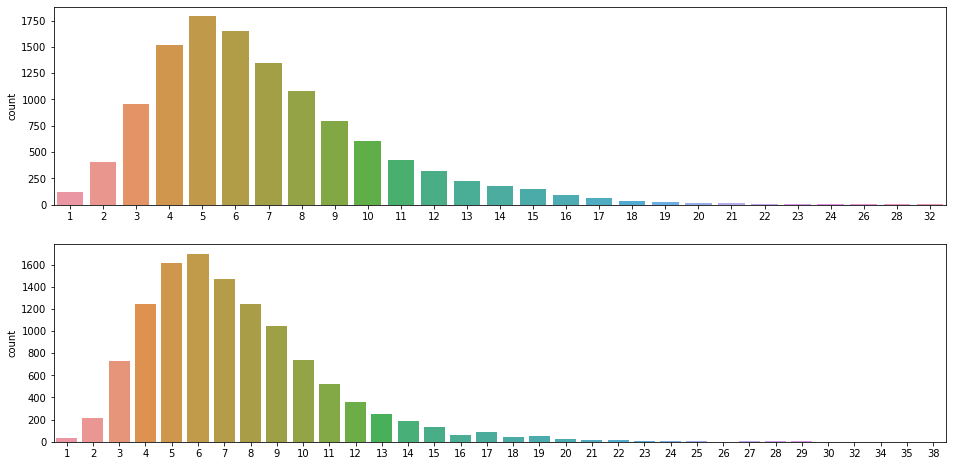

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
plt.subplot(211)
sns.countplot([len(i) for i in questions])
plt.subplot(212)
sns.countplot([len(i) for i in answers])
plt.show()

In [109]:
# 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
min_len = 2
max_len = 13

que_corpus = []
ans_corpus = []

for q, a in zip(questions, answers):
    if min_len < len(q) < max_len and min_len < len(a) < max_len:
        que_corpus.append(q)
        ans_corpus.append(a)

print(len(que_corpus))
print(len(ans_corpus))

9503
9503


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


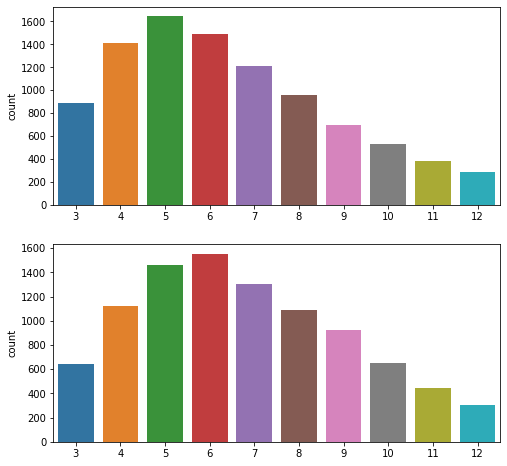

In [111]:
import seaborn as sns

plt.figure(figsize=(8, 8))
plt.subplot(211)
sns.countplot([len(i) for i in que_corpus])
plt.subplot(212)
sns.countplot([len(i) for i in ans_corpus])
plt.show()

In [90]:
# def build_corpus(source,
#                  target): # input and target data are parameters
#     # preprocessing with preprecess func
#     questions = list(map(preprocess_sentence, source))
#     answers = list(map(preprocess_sentence, target))
    
#     # transfer into mecab.morphs() method
#     Q_tokens = [] # clean Q token
#     A_tokens = [] # clean A token
    
#     for sen in questions:
#         for token in mecab.morphs(sen):
#             if token in Q_tokens:
#                 continue
#             Q_tokens.append(token)
                

#     for sen in answers:
#         for token in mecab.morphs(sen):
#             if token in A_tokens:
#                 continue
#             A_tokens.append(token)
            
            
#     # excludes sentence which has more tokens num we set
#     from tqdm.notebook import tqdm    # Process 과정을 보기 위해

#     src_corpus = []
#     tgt_corpus = []

#     assert len(kor_corpus) == len(eng_corpus)

#     # 토큰의 길이가 50 이하인 문장만 남깁니다. 
#     for idx in tqdm(range(len(kor_corpus))):
#         tokens = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
#         tokensen = en_tokenizer.EncodeAsIds(eng_corpus[idx])

#         if 3 < len(tokensko) < 50 and 6 < len(tokensen) < 50:
#             src_corpus.append(tokensko)
#             tgt_corpus.append(tokensen)

#     # 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
#     enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
#     dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')    
#     # delete duplicates
    
#     return que_corpus, ans_corpus, enc_train, dec_train

In [91]:
# que_corpus, ans_corpus, enc, dec = build_corpus(total_cleaned_corpus_sample['Q'],total_cleaned_corpus_sample['A'])

NameError: name 'kor_corpus' is not defined

## Step 4. Augmentation
우리에게 주어진 데이터는 1만 개가량으로 적은 편에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? Lexical Substitution을 실제로 적용해 보도록 하겠습니다.

아래 링크를 참고하여 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다. Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!

- [Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

다운로드한 모델을 활용해 데이터를 Augmentation 하세요! 앞서 정의한 lexical_sub() 함수를 참고하면 도움이 많이 될 겁니다.

Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

In [114]:
# Install the gensim library if you don't have it already
!pip install --upgrade gensim==3.8.3

In [117]:
# Import the KeyedVectors class from the gensim.models module
from gensim.models import KeyedVectors 
import gensim


# Load the word2vec model from ko.bin
wordvec = os.getenv('HOME')
ko_bin = '/aiffel/songys_chatbot/Data/ko.bin'
wordvec += ko_bin
word2vec = gensim.models.Word2Vec.load(wordvec)
# model = KeyedVectors.load_word2vec_format(wordvec, binary=True, encoding='utf-8')

#유사한 단어와 그 유사도 확인
word2vec.wv.most_similar("결혼")

[('재혼', 0.860297679901123),
 ('약혼', 0.8294124603271484),
 ('혼인', 0.8150444030761719),
 ('동침', 0.7147324085235596),
 ('사별', 0.7103983163833618),
 ('이혼', 0.6888260841369629),
 ('재회', 0.645790159702301),
 ('결별', 0.6362689137458801),
 ('교제', 0.6243669986724854),
 ('헤어지', 0.6122138500213623)]

## Step 5. 데이터 벡터화
타겟 데이터인 ans_corpus 에 <start> 토큰과 <end> 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 ans_corpus 는 list 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!

In [118]:
sample_data = ["12", "시", "땡", "!"]

print(["<start>"] + sample_data + ["<end>"])

['<start>', '12', '시', '땡', '!', '<end>']


위 소스를 참고하여 타겟 데이터 전체에 \<start\> 토큰과 \<end\> 토큰을 추가해 주세요!
챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것이겠죠. 앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

특수 토큰을 더함으로써 ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 enc_train 과 dec_train 을 얻으세요!


In [119]:
def Tokenize(src, tgt, max_len):
    tensor = []
    
    for sentence in src:
        tensor.append(sentence)
    
    for sentence in tgt:
        tensor.append([""] + sentence + [""])
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(tensor)
    tensor = tokenizer.texts_to_sequences(tensor)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='post')
    
    src_corpus = tensor[:len(src)]
    tgt_corpus = tensor[len(tgt):]
    
    return src_corpus, tgt_corpus, tokenizer

In [120]:
MAX_LEN = 14

enc_train, dec_train, tokenizer = Tokenize(que_corpus, ans_corpus, MAX_LEN)

print(enc_train.shape)
print(dec_train.shape)
print('단어장의 크기 :', len(tokenizer.word_index))

(9503, 14)
(9503, 14)
단어장의 크기 : 6099


In [121]:
for i in range(16):
    print('>> ', enc_train[i])
    print('>> ', [tokenizer.index_word[word] for word in enc_train[i] if word != 0])
    print('>> ', dec_train[i])
    print('>> ', [tokenizer.index_word[word] for word in dec_train[i] if word != 0])
    print()

>>  [ 855  114    3   37  658 4112   23   30  216   92   18    0    0    0]
>>  ['장거리', '연애', '하', '면', '보통', '몇일', '에', '한', '번', '만나', '?']
>>  [  1 412  23 339 630  16  54 549   1   0   0   0   0   0]
>>  ['', '상황', '에', '따라', '다르', '지', '않', '을까요', '']

>>  [1103  717 1542    0    0    0    0    0    0    0    0    0    0    0]
>>  ['도시락', '싸', '봐야지']
>>  [  1 228  20 200   1   0   0   0   0   0   0   0   0   0]
>>  ['', '맛있', '게', '드세요', '']

>>  [ 17 332  14  10  32  21   0   0   0   0   0   0   0   0]
>>  ['나', '속', '은', '거', '같', '아']
>>  [   1  398  304 2806   83    1    0    0    0    0    0    0    0    0]
>>  ['', '다음', '부터', '속지', '마세요', '']

>>  [ 162   19  778 4113    0    0    0    0    0    0    0    0    0    0]
>>  ['아직', '도', '그대로', '인걸']
>>  [  1 582   4  96  34   2  22  28   1   0   0   0   0   0]
>>  ['', '변하', '는', '건', '사랑', '이', '겠', '죠', '']

>>  [2044   84 1543  686   53   35  192   21    0    0    0    0    0    0]
>>  ['인터넷', '에서', '바지', '샀', '는데', '안', '맞

### 모델 설계

In [122]:
BATCH_SIZE = 64
BUFFER_SIZE = 24000

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE).batch(batch_size=BATCH_SIZE)
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask
# Multi Head Attention 구현

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='gelu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [123]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        self.n_heads = n_heads
        self.d_ff = d_ff
        self.drop = dropout
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [125]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
d_model = 368

transformer = Transformer(
    n_layers=1,
    d_model=d_model,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=32,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True)
# Learning Rate Scheduler 구현

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)


learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns
def translate(tokens, model, tokenizer):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tokenizer.word_index['']], 0)
    
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        
        if predicted_id == tokenizer.word_index['']:
            result = [tokenizer.index_word[i] for i in ids]
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = [tokenizer.index_word[i] for i in ids]
    
    return result

## Step 6. 훈련하기
앞서 번역 모델을 훈련하며 정의한 Transformer 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! 가장 멋진 답변과 모델의 하이퍼파라미터를 제출하시면 됩니다.

    
```
# 예문
1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

---

# 제출

Translations
> 1. 잠깐 쉬 어도 돼요 . <end>
> 2. 맛난 거 드세요 . <end>
> 3. 떨리 겠 죠 . <end>
> 4. 좋 아 하 면 그럴 수 있 어요 . <end>

Hyperparameters
> n_layers: 1
> d_model: 368
> n_heads: 8
> d_ff: 1024
> dropout: 0.2

Training Parameters
> Warmup Steps: 1000
> Batch Size: 64
> Epoch At: 10
```

In [126]:
examples = [
            "지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."
]

def ChatBot(inputs, model, tokenizer):
    sentence = preprocess_sentence(inputs)
    sentence = Mecab().morphs(sentence)
    tokens = tokenizer.texts_to_sequences([sentence])
    
    candidate = ' '.join(translate(tokens, model, tokenizer))
    
    print('Q :', inputs)
    print('A :', candidate)

In [127]:
# 훈련시키기
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
    
    for ex in examples:
        ChatBot(ex, transformer, tokenizer)
        print()
    
    print('Loss :', (total_loss.numpy() / (step + 1)))
    print('Epoch At :', epoch + 1)

print('='*50)
print('Hyperparameters')
print('> n_layers :', transformer.encoder.n_layers)
print('> d_model :', d_model)
print('> n_heads :', transformer.n_heads)
print('> d_ff :', transformer.d_ff)
print('> dropout :', transformer.drop)
print()

print('Training Parameters')
print('> Warmup Steps :', learning_rate.warmup_steps)
print('> Batch Size :', BATCH_SIZE)

  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 마음 이 에요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 저 도 좋 은 사람 이 에요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 마음 이 에요

Q : 집에 있는다는 소리야.
A : 많이 사람 이 에요

Loss : 5.916416654650797
Epoch At : 1


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 도 하 고 있 어요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 저 도 좋 아요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 친구 가 있 으면 좋 아요

Q : 집에 있는다는 소리야.
A : 제 가 있 잖아요

Loss : 3.8193515035130035
Epoch At : 2


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 도 데려가 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 오늘 은 쉬 는 게 좋 을 거 같 아요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 대화 를 하 세요

Q : 집에 있는다는 소리야.
A : 집 마련 이 죠

Loss : 2.8312037935192955
Epoch At : 3


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 여유 를 찾아보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 정신 차리 세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 좋 은 소식 이 었 네요

Q : 집에 있는다는 소리야.
A : 내 집 에서 도 있 죠

Loss : 1.93914794921875
Epoch At : 4


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 는 성 이 있 다면 요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 해결 되 기 도 합니다

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 같이 해 주 세요

Q : 집에 있는다는 소리야.
A : 내 집 마련 이 네요

Loss : 1.3909722654611472
Epoch At : 5


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 당신 은 다 들 고 살 수 있 어요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 오늘 웬수 죠

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 오랜만 에 하나 봐요

Q : 집에 있는다는 소리야.
A : 좋 은 만남 이 죠

Loss : 1.1423761764628775
Epoch At : 6


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 도 보 고 싶 어요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 시간 고생 이 많 으시 군요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 그 친구 랑 좋 은 인연 이 죠

Q : 집에 있는다는 소리야.
A : 같이 같이 같이 같이 같이 공감 이 되 네요

Loss : 1.080440034802328
Epoch At : 7


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 도 모르 는 게 좋 을 거 예요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 잘못 입니다

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 이제 관심 이 필요 하 죠

Q : 집에 있는다는 소리야.
A : 연락 할 못 드 는 부분 도 부분 이 에요

Loss : 0.9205561900298868
Epoch At : 8


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 마음 에 따라 얼마 든지 바뀔 수 있 어요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 이제 일어날 시간 이 에요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 좋 은 취미 가 기 는 거 죠

Q : 집에 있는다는 소리야.
A : 제 가 기대 집 에서 나가 봐요

Loss : 0.7062732261299287
Epoch At : 9


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 도 보 고 싶 은 사람 들 이 해 보 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 잠 이 에요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 내 집 차이 야경 이 죠

Q : 집에 있는다는 소리야.
A : 힘든 결정 이 었 을 때 네요

Loss : 0.5664332857067953
Epoch At : 10


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 도 보 고 싶 을 거 예요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 잠깐 의 눈 을 먹 어 보 세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 슬픈 이야기 네요

Q : 집에 있는다는 소리야.
A : 좋 아 가 만 있 죠

Loss : 0.46825972179438446
Epoch At : 11


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 나가 면 좀 더 기다려 주 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 스트레스 받 지 마세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 같이 안 하 게 좋 겠 네요

Q : 집에 있는다는 소리야.
A : 제 가 위로 해 드릴게요

Loss : 0.38943251027356857
Epoch At : 12


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 지금 도 좋 아요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 뭘 으로 사 는 것 도 나쁘 지 않 아요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 환승 은 30 분 안 에

Q : 집에 있는다는 소리야.
A : 같이 살 면서 알 면서 같이 돼요

Loss : 0.33012438780509384
Epoch At : 13


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 도 모르 고 살 고 싶 네요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 내일 은 쉬 어야 충전 되 었 나 봐요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 야경 이 예쁜 곳 은 알 세요

Q : 집에 있는다는 소리야.
A : 같이 가 참 고 좋 죠

Loss : 0.2858136068254509
Epoch At : 14


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 제 가 있 잖아요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 잠 을 깨 푹 쉬 세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 삶 은 선택 의 연속 이 에요

Q : 집에 있는다는 소리야.
A : 제 가 같이 가 있 어 드릴게요

Loss : 0.2514313819424418
Epoch At : 15


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 도 데려가 주 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 푹 쉬 세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 같이 등산 해요

Q : 집에 있는다는 소리야.
A : 제 가 한 때 가 있 죠

Loss : 0.2257478957208211
Epoch At : 16


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 제 가 생각 해도 저 도 데려가 주 세요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 오늘 일찍 주무세요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 그 친구 랑 좋 은 연애 로 소중 해요

Q : 집에 있는다는 소리야.
A : 참 는 게 좋 죠

Loss : 0.20808698666975803
Epoch At : 17


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 저 도 보 고 싶 어요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 쉬 어야 충전 시간 이 죠

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 멋진 사람 이랑 같이 가보세요

Q : 집에 있는다는 소리야.
A : 제 가 있 잖아요

Loss : 0.18103951575772073
Epoch At : 18


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 마음 에 도 고생 했어요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 이제 일어날 시간 이 에요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 그 사람 도 아닌 것 같 아요

Q : 집에 있는다는 소리야.
A : 제 가 알 아요

Loss : 0.16975662692281224
Epoch At : 19


  0%|          | 0/149 [00:00<?, ?it/s]

Q : 지루하다, 놀러가고 싶어.
A : 에 저 랑 이야기 해요

Q : 오늘 일찍 일어났더니 피곤하다.
A : 운동 으로 땀 을 내보 세요 한결 몸 이 가벼워질 거 예요

Q : 간만에 여자친구랑 데이트 하기로 했어.
A : 그 것 도 그 자체 가 행복 해 본 야경 이 죠

Q : 집에 있는다는 소리야.
A : 같이 알 면서 도 데이 는 것

Loss : 0.15575104271805526
Epoch At : 20
Hyperparameters
> n_layers : 1
> d_model : 368
> n_heads : 8
> d_ff : 1024
> dropout : 0.2

Training Parameters
> Warmup Steps : 1000
> Batch Size : 64


# 회고

이번실습에서 성능평가와 데이터 증강은 실습하지 못했습니다.
데이터 증강이 기대됐는데 생각보다 구현하는데 어려움이 있었습니다.

Mecab을 써서 형태소를 구분했고, 한국말 사전 학습된 Word2vec을 사용해봤습니다.
이렇게 챗봇을 만들었는데, 대화가 되긴하는데 뭔가 만족스러운 결과를 보여주지는 못했습니다.

성능향상을 시키기 위해 어떤 것들이 더 필요할 지 궁금합니다.

- Mecab 대신 Sentence-piece를 쓰면 더 좋아질까?
- word2vec보다 더 나은 방식으로 백터화 시킬 수 없을까?